In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")

In [4]:
dev = tch.device("cuda")
dtype = tch.float32

In [5]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [6]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [15]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
latent_dim = 64

conv_channels = [[1, 2], [2, 4], [4, 8]]
kernel_size = 5
fc_dims = [392, 128]

gen = Decoder([latent_dim, *reversed(fc_dims)], [list(reversed(s)) for s in reversed(conv_channels)], kernel_size, image_dims).to(dev)
print(gen)
dis = Encoder(image_dims, conv_channels, kernel_size, [*fc_dims, 1]).to(dev)
print(dis)

Decoder(
  (mlp): Mlp(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=392, bias=True)
  )
  (up_conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (pool): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
    )
    (1): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (pool): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
    )
    (2): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
    )
  )
)
Encoder(
  (conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (

In [16]:
batch_size = 256
ratio = 1.0

gen_optim = tch.optim.AdamW(
    gen.parameters(),
    lr=1e-3,
)
dis_optim = tch.optim.AdamW(
    dis.parameters(),
    lr=1e-4,
)

In [17]:
def sample_fig(z: Tensor):
    gen.train(False)

    n = z.shape[0]
    images = gen.forward(z).detach().to("cpu").numpy()
    fig, axs = plt.subplots(1, n)
    for i in range(n):
        ax = axs[i]
        ax.axis('off')
        ax.imshow(images[i], interpolation='nearest')

    return fig

'epoch = 99'

{'loss': np.float64(1.721831445815661e-05)}

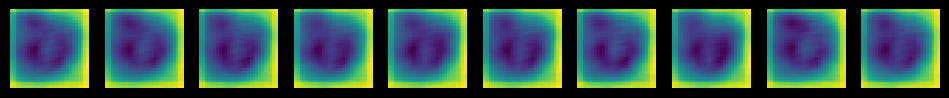

In [18]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.utils import Accum
from IPython.display import display, clear_output

test_noise = tch.randn((10, latent_dim), device=dev)

for epoch in range(100):

    gen.train(True)
    dis.train(True)

    stats = Accum("loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        gen.zero_grad()
        dis.zero_grad()

        z = tch.randn((int(batch_size * ratio), latent_dim), device=dev)
        x_fake = gen.forward(z)

        x_real = images
        x = tch.cat((x_real, x_fake), 0)
        labels = tch.cat((tch.zeros(x_real.shape[0]), tch.ones(x_fake.shape[0])), 0).to(dev)
        logits = dis.forward(x).squeeze(1)

        loss = bce_with_logits(logits, labels)

        loss.backward()
        dis_optim.step()

        for p in gen.parameters():
            p.grad = -p.grad
        gen_optim.step()

        stats.append(loss.item())

    clear_output()
    display(f"{epoch = }", )
    display(stats.mean())
    display(sample_fig(test_noise))
    plt.close()

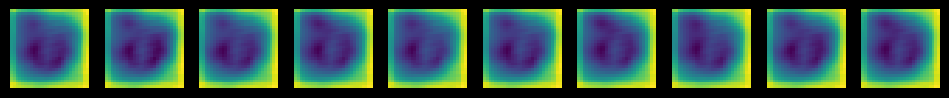

In [19]:
sample_fig(tch.randn((10, latent_dim), device=dev)).show()